In [4]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 6.8 MB/s 
     |████████████████████████████████| 965 kB 65.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

<Figure size 432x288 with 0 Axes>

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
df_replies = pd.read_excel('replies.xlsx')

In [4]:
df_replies.head()

,tweetId,replyTo,text,created_at,quotes,favorites,replies,retweets,hashtags,userId,username,name,followers,following,verified
0,1.587272e+18,1.587173e+18,@SenatorLankford Ever thought of this? ⬇️ \nht...,Tue Nov 01 02:35:46 +0000 2022,0,0,0,0,[],329475579,TulsaGeography,Stephen E Schneider,1091,1121,False
1,1.587240e+18,1.587173e+18,@SenatorLankford Well I guess not tweeting fo...,Tue Nov 01 00:27:49 +0000 2022,0,2,0,1,[],1091819093395758976,JaneDoke,JaneDoke,11,18,False
2,1.587229e+18,1.587173e+18,@SenatorLankford Happy Halloween 🎃,Mon Oct 31 23:45:52 +0000 2022,0,0,0,0,[],1190651159951953920,Marmaluke2,Marmaluke,75,1379,False
3,1.587182e+18,1.587173e+18,@SenatorLankford Nothing on leader Pelosi’s hu...,Mon Oct 31 20:37:39 +0000 2022,0,3,0,1,[],1476031468300292096,LindaQ59,Calvin & hobbs,44,35,False
4,1.587176e+18,1.583121e+18,@SenatorLankford Kinda like you being silent o...,Mon Oct 31 20:12:20 +0000 2022,0,0,0,0,[],1457967491926437888,smokeajointtt,Craig Thomas,600,1854,False


In [5]:
df_replies[df_replies.duplicated()]

,tweetId,replyTo,text,created_at,quotes,favorites,replies,retweets,hashtags,userId,username,name,followers,following,verified


In [6]:
df_replies['created_at'] = pd.to_datetime(df_replies['created_at'])

In [8]:
replies_per_day = df_replies['created_at'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

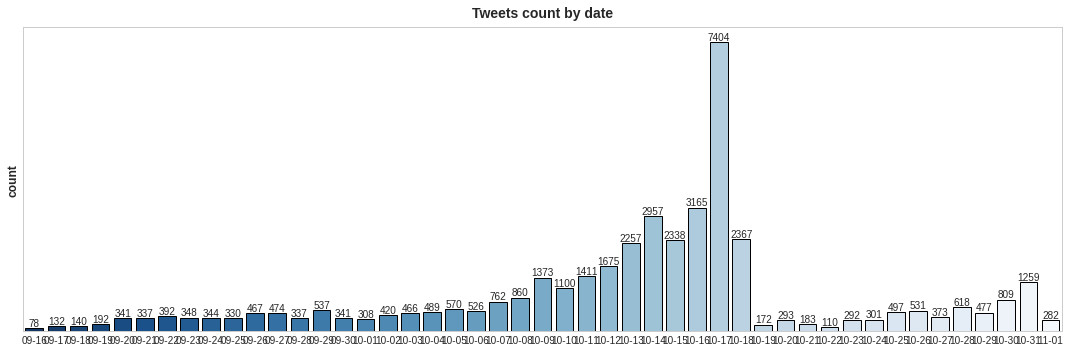

In [9]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='index', y='counts', data=replies_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [10]:
replies_per_hour = df_replies['created_at'].dt.strftime('%H').value_counts().sort_index().reset_index(name='counts')

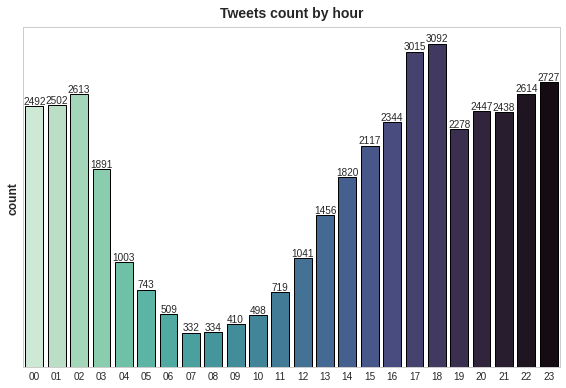

In [11]:
plt.figure(figsize=(8,5.5))
ax = sns.barplot(x='index', y='counts', data=replies_per_hour,edgecolor = 'black',ci = False, palette='mako_r')
plt.title('Tweets count by hour')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

**Using Vader on the whole dataset (uncleaned)**

In [12]:
sia_vader = SentimentIntensityAnalyzer()

In [13]:
sentiments = []
for tweet in df_replies.text:
    sentiment_dict = sia_vader.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments.append(max(sentiment_dict , key=sentiment_dict.get))

In [15]:
df_replies['sentiment'] = sentiments
df_replies['sentiment'].value_counts()

neu    39252
pos     1158
neg     1025
Name: sentiment, dtype: int64

## Dataset Cleaning

In [16]:
## Function to strip all entities

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [17]:
## Function to clean hashtags

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [18]:
## Function to clear special characters

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [19]:
## Function to remove multiple spaces

def remove_mult_spaces(text): ## remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [20]:
def remove_spam(text):
    match = re.search(r'subscribe', text)
    if match:
        return ''
    else:
        return text


In [21]:
texts_new = []
for t in df_replies.text:
    texts_new.append(remove_spam(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t))))))

In [22]:
df_replies['text_clean'] = texts_new 

In [23]:
df_replies['text_clean'].head()

0                                 ever thought of this
1    well i guess not tweeting for 4 days will excu...
2                                      happy halloween
3    nothing on leader pelosis husband latest repor...
4    kinda like you being silent on the paul pelosi...
Name: text_clean, dtype: object

In [24]:
df_replies['text_clean'] = df_replies['text_clean'].str.lower()

In [26]:
text_len = []
for text in df_replies.text_clean:
    reply_len = len(text.split())
    text_len.append(reply_len)

In [27]:
df_replies['text_len'] = text_len

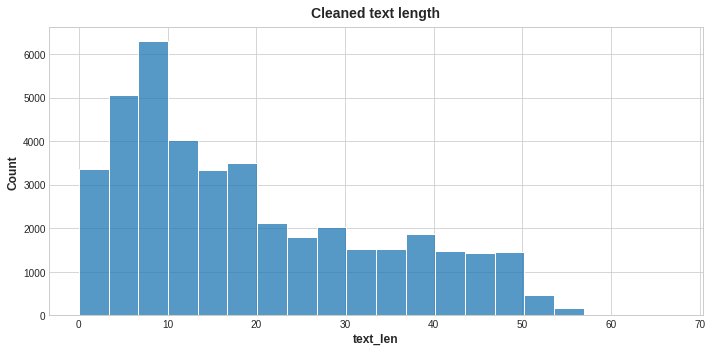

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(x='text_len', data=df_replies, bins=20)
plt.title('Cleaned text length')
plt.show()

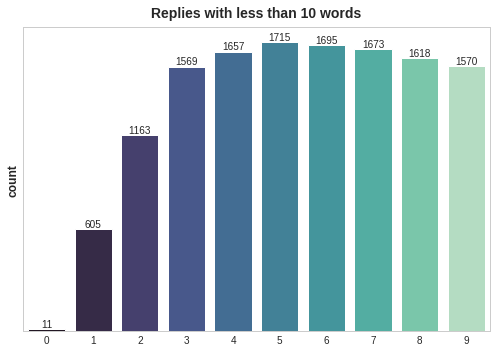

In [31]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_replies[df_replies['text_len'] < 10], palette='mako')
plt.title('Replies with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [32]:
## Deletion of small-length replies

df_replies = df_replies[df_replies['text_len'] > 2]

## Vader

In [33]:
## Initialize the Vader learner

sia_vader = SentimentIntensityAnalyzer()

In [34]:
## Fitting the vader

sentiments_vader = []
for reply in df_replies.text_clean:
    sentiment_dict = sia_vader.polarity_scores(reply)
    sentiment_dict.pop('compound', None)
    sentiments_vader.append(max(sentiment_dict , key=sentiment_dict.get))

**Using Vader on the cleaned dataset**

In [35]:
df_replies['sentiment_vader'] = sentiments_vader
df_replies['sentiment_vader'].value_counts()

neu    36846
neg     1429
pos     1381
Name: sentiment_vader, dtype: int64

## TextBlob

In [40]:
def polarity_to_text(blob):
    if (blob.sentiment.polarity > 0.1):
        return 'pos'
    elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.05):
        return 'neu'
    else:
        return 'neg'

In [41]:
sentiments_blob = []
for reply in df_replies.text_clean:
    blob = TextBlob(reply)
    sentiments_blob.append(polarity_to_text(blob))

<AxesSubplot:>

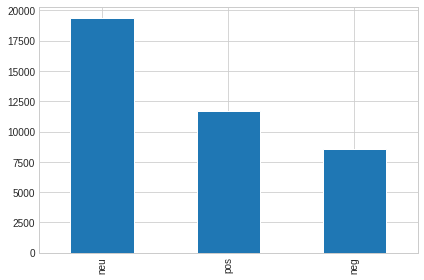

In [43]:
df_replies['sentiment_blob'] = sentiments_blob
df_replies['sentiment_blob'].value_counts().plot(kind='bar')

## Flair Analysis 

In [ ]:
flair_clf = TextClassifier.load('sentiment-fast');

2022-11-05 02:03:53,983 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmp9o09gxkp


100%|██████████| 1241977025/1241977025 [01:10<00:00, 17493337.54B/s]

2022-11-05 02:05:05,513 copying /tmp/tmp9o09gxkp to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2022-11-05 02:05:10,331 removing temp file /tmp/tmp9o09gxkp
2022-11-05 02:05:10,551 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


In [ ]:
def emotion_threshold(emo, val):
    if (emo =='POSITIVE') & (val >= 0.7):
        return 'pos'
    elif(emo =='NEGATIVE') & (val >= 0.7):
        return 'neg'
    else:
        return 'neu' 

In [ ]:
sentiments_flair = []
for tweet in df_tweets.text_clean:
    sentence = Sentence(tweet)
    flair_clf.predict(sentence)
    emo = re.findall(r'([A-Z]+\b)',str(sentence.labels))[0]
    val = float(re.findall(r"([+-]?[0-9]*[.]?[0-9]+)",str(sentence.labels))[0]) #extract the confidence value for the emotion
    sentiments_flair.append(emotion_threshold(emo,val))

In [ ]:
df_tweets['sentiment_flair'] = sentiments_flair
df_tweets['sentiment_flair'].value_counts()

## WordCloud creations

### Positive Replies

In [44]:
stopwords = ["amp","vote", 'will', 'great', 'im', 'u', "new",'u','s','t'] + list(STOPWORDS)

In [46]:
texts_vader_pos = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_vader']=='pos']['text_clean'])
texts_nltk_pos = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_nltk']=='pos']['text_clean'])
texts_blob_pos = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_blob']=='pos']['text_clean'])
texts_flair_pos = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_flair']=='pos']['text_clean'])

In [48]:
wordcloud_vader_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_vader_pos)



In [49]:
wordcloud_blob_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_pos)
wordcloud_flair_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_flair_pos)

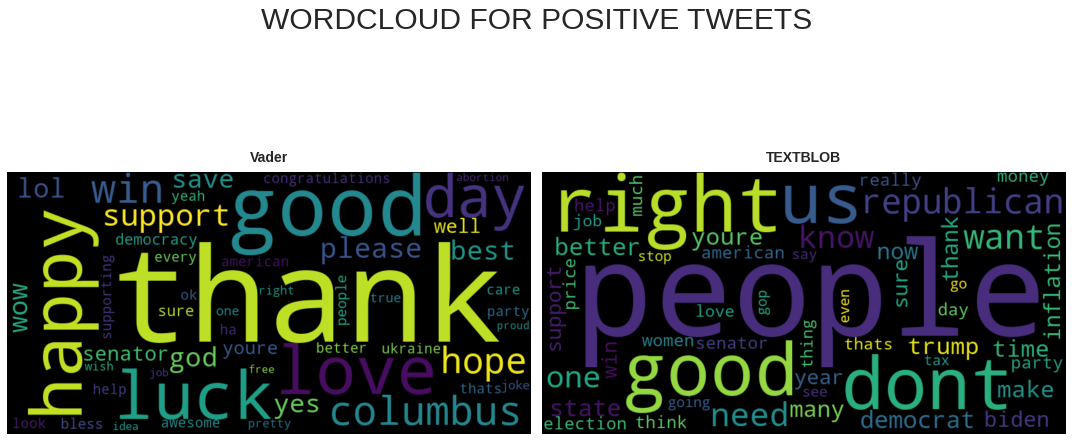

In [52]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
plt.suptitle('WORDCLOUD FOR POSITIVE TWEETS', fontsize=30)

ax[0].imshow(wordcloud_vader_pos, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Vader')

ax[1].imshow(wordcloud_blob_pos, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('TEXTBLOB')


#ax[1,1].imshow(wordcloud_flair_pos, interpolation="bilinear")
#ax[1,1].axis("off")
#ax[1,1].set_title('FLAIR')
plt.tight_layout()
plt.show()

In [55]:
## Creation of a dataframe with all positive classified replies

df_all_pos = df_replies[(df_replies['sentiment_vader']=='pos') & (df_replies['sentiment_blob']=='pos')]

In [56]:
len(df_all_pos)

923

In [57]:
df_all_pos['text_clean'].sample(10).values

array(['russian puppet a endorses russian puppet b fantastic',
       'youre gonna lose hahaha',
       'hello my son please watch and share my video ok i love you and please lets stay in touch ok and thank you ok',
       'pretty sure biden did that even before the hurricane hit so yeah nice bluster',
       'secure the border', 'yes by winning voteblue',
       'nice try b i t c h',
       'if i lived there i would happily vote for really hoping he wins',
       'this is amazing', 'happy columbus day'], dtype=object)

In [58]:
texts_pos = " ".join(sentiment for sentiment in df_all_pos['text_clean'])

In [59]:
wordcloud_pos = WordCloud(width=900,
                      stopwords=stopwords,
                      height=500,
                      max_font_size=300,
                      max_words=100,
                      collocations=False,
                      background_color='black').generate(texts_pos)

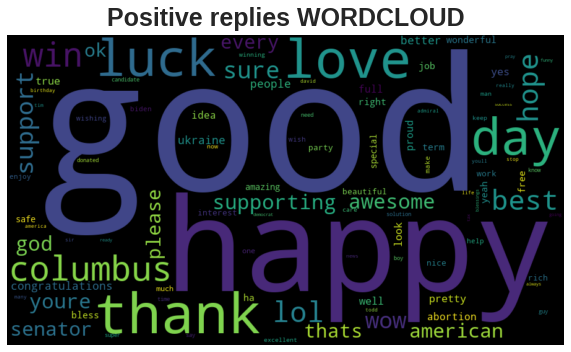

In [61]:
plt.figure(figsize=(9,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive replies WORDCLOUD', fontsize=25)
plt.show()

### Negative Replies

In [63]:
texts_vader_neg = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_vader']=='neg']['text_clean'])
texts_nltk_neg = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_nltk']=='neg']['text_clean'])
texts_blob_neg = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_blob']=='neg']['text_clean'])
#texts_flair_neg = " ".join(sentiment for sentiment in df_replies[df_replies['sentiment_flair']=='neg']['text_clean'])

In [64]:
wordcloud_vader_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_vader_neg)

wordcloud_blob_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_neg)

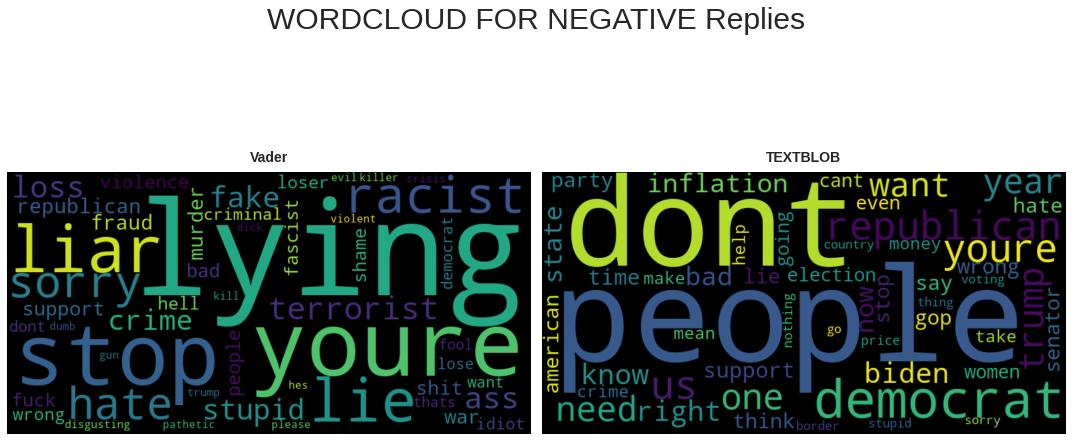

In [65]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
plt.suptitle('WORDCLOUD FOR NEGATIVE Replies', fontsize=30)

ax[0].imshow(wordcloud_vader_neg, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Vader')

ax[1].imshow(wordcloud_blob_neg, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('TEXTBLOB')


#ax[1,1].imshow(wordcloud_flair_neg, interpolation="bilinear")
#ax[1,1].axis("off")
#ax[1,1].set_title('FLAIR')

plt.tight_layout()

plt.show()

In [68]:
## Creation of dataframe with all negatively classified replies
df_all_neg = df_replies[(df_replies['sentiment_vader']=='neg')  & (df_replies['sentiment_blob']=='neg')] # (df_replies['sentiment_flair']=='pos')]

In [69]:
len(df_all_neg)

615

In [70]:
texts_neg = " ".join(sentiment for sentiment in df_all_neg['text_clean'])


In [71]:
wordcloud_neg = WordCloud(width=900,
                      stopwords=stopwords,
                      height=500,
                      max_font_size=200,
                      max_words=60,
                      collocations=False,
                      background_color='black').generate(texts_neg)

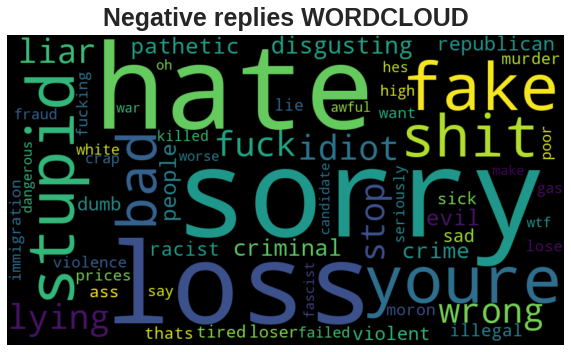

In [73]:
plt.figure(figsize=(9,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Negative replies WORDCLOUD', fontsize=25)
plt.show()

In [75]:
df_replies.sentiment_vader.value_counts()

neu    36846
neg     1429
pos     1381
Name: sentiment_vader, dtype: int64

In [76]:
df_replies.sentiment_nltk.value_counts()

neu    39656
Name: sentiment_nltk, dtype: int64

In [77]:
df_replies.sentiment_blob.value_counts()

neu    19343
pos    11731
neg     8582
Name: sentiment_blob, dtype: int64